#### 1. [DACON] 코드 유사성 판단 시즌2 AI 경진대회
- C++ 코드간의 유사성을 판단할 수 있는 AI 알고리즘 개발
- https://dacon.io/competitions/official/236228/overview/description

---
1-1. Sentence-Transformer | 101_sentence_transformer.ipynb
- sentence transformer(all-mpnet)를 Contrastive Learning 방식으로 파인 튜닝하여 두개의 C++ 코드 쌍이 동일한 문제를 해결하는 코드인지 유사성을 판단하는 방법

#### 0. Preparation 

In [1]:
!nvidia-smi

Sun Mar 31 08:43:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1]:
!pip install accelerate datasets pytorch_metric_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━

데이터 다운로드
- open.zip 파일 구성은 다음과 같음

	train_code [Folder] : 학습용으로 주어지는 500개의 문제에 대한 코드

		├ problem001 : 문제 번호

		│	├ problem001_1.cpp : 문제(001)를 해결하려는 솔루션 코드 1

		│	├ problem001_2.cpp : 문제(001)를 해결하려는 솔루션 코드 2

		│	└ problem001_...

		├ problem002 : 문제 번호

		│	├ problem002_1.cpp : 문제(002)를 해결하려는 솔루션 코드 1

		│	├ problem002_2.cpp : 문제(002)를 해결하려는 솔루션 코드 2

		│	└ problem002_...

		└ ...

	test.csv [File] : 학습 데이터에 없는 다른 문제에 대한 코드 중에서 595000개의 Pair 쌍으로 이루어진 테스트용 데이터셋

		│	├ pair_id : 각 pair 쌍에 부여되는 id 번호

		│	├ code1 : 유사성을 비교할 C++ 코드 1

		│	└ code2 : 유사성을 비교할 C++ 코드 2

		│

In [2]:
!gdown 13WixS0gfcsb7NkKGje6QZA1phPlVhKQm

Downloading...
From (original): https://drive.google.com/uc?id=13WixS0gfcsb7NkKGje6QZA1phPlVhKQm
From (redirected): https://drive.google.com/uc?id=13WixS0gfcsb7NkKGje6QZA1phPlVhKQm&confirm=t&uuid=d28b9d4a-5c94-45d3-97b5-6b29b0fd4fcc
To: /content/open.zip
100% 485M/485M [00:08<00:00, 56.5MB/s]


In [1]:
import torch
import random
import numpy as np
import torch.backends.cudnn as cudnn

def seed_everything(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  cudnn.benchmark=False
  cudnn.deterministic=True
  random.seed(seed)

SEED = 555
seed_everything(SEED)

import warnings
warnings.filterwarnings('ignore')

#### 1. Load Model
- all_mpnet-base-v2 (https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)


Sentence embeddings:
tensor([[ 0.0225, -0.0783, -0.0230,  ..., -0.0083,  0.0265, -0.0020],
        [ 0.0417,  0.0011, -0.0155,  ..., -0.0218, -0.0636, -0.0088]])


#### 2. Train Data Generator

In [3]:
import random
from zipfile import ZipFile
from collections import defaultdict

class TrainDataset(torch.utils.data.Dataset):
  def __init__(self, zip_file_path="/content/open.zip", sampling=False):
    super().__init__()
    self.zip_file_path = zip_file_path

    with ZipFile(zip_file_path, 'r') as zipfile:
      train_code_folder = 'train_code/'
      all_files = zipfile.namelist()
      # zip 파일 내 모든 cpp 파일 리스트
      self.cpp_files = [file for file in all_files if file.startswith(train_code_folder) and file.endswith('.cpp')]
      # 문제 번호별로 cpp 파일 분류
      self.problems = defaultdict(list)
      for _cpp_file in self.cpp_files:
        problem = _cpp_file.split('/')[1]
        # 검증셋으로 쓸 솔루션 코드 샘플링
        if sampling and len(self.problems[problem])>=2:
          pass
        else:
          # cpp 파일을 string으로
          with zipfile.open(_cpp_file, 'r') as zf:
            cpp_code = zf.read().decode('utf-8')
            self.problems[problem].append(cpp_code)
      # 검증셋 코드 필터링
      if not sampling:
        dict((k, v[2:]) for k, v in self.problems.items() if len(v)>=4)
      self.problem_keys = list(self.problems.keys())

  def __len__(self):
    return len(self.problem_keys)

  def __getitem__(self, idx):
    '''
    데이터셋 호출 시, 
    동일한 문제의 솔루션 코드 2개를 랜덤으로 추출하여 {'code1': , 'code2': }와 같이 반환 (positive pair)
    '''
    key = self.problem_keys[idx]
    code1, code2 = random.sample(self.problems[key], 2)
    return {'code1': code1, 'code2': code2}

In [7]:
trn_ds = TrainDataset(zip_file_path="/content/open.zip")
print(f'Total Size of Train Dataset: {len(trn_ds)}')

val_ds = TrainDataset(zip_file_path="/content/open.zip", sampling=True)
print(f'Total Size of Valid Dataset: {len(val_ds)}')

Total Size of Train Dataset: 500
Total Size of Valid Dataset: 500


#### 3. Train

In [4]:
import transformers
from pytorch_metric_learning import losses

class Trainer(transformers.Trainer):
  '''
  Custom Transformer Trainer 정의

  NTXentLoss 사용하여 cpp 코드의 유사성을 학습하는 모델 훈련 (ICML'2020, A Simple Framework for Contrastive Learning of Visual Representations, https://arxiv.org/abs/2002.05709)
  NTXentLoss는 positive sample과의 유사도를 1과 가깝게, negative sample과의 유사도를 0과 가깝게 만드는 목적 함수이다.

  두 코드가 주어졌을 때, 동일한 문제를 위한 코드인 경우 positive pair, 서로 다른 문제를 위한 코드인 경우 negative pair 라고 하자.
  
  예를 들어, 배치 사이즈가 3일때
  문제 A, B, C에 대한 위에서 정의한 학습 데이터셋(TrainDataset)을 호출하면 각각 2 개, 총 6 개의 솔루션 코드(A-1, A-2, B-1, B-2, C-1, C-2)가 생성된다.
  이때, 코드 A-1를 anchor라고 할 때 A-2는 anchor의 positive sample이 되고 A-2를 제외한 B-1, B-2, C-1, C-2는 negative sample이 된다. 
  즉, anchor의 positive pair는 1 개, negative pair는 4 개이며, 
  총 6개(=3*2)의 코드가 있으므로 배치 내 positive pair는 6개(=6*1), negative pair는 24개(=6*4)가 된다.
  모델은 positive pair들의 유사도를 최대화하고 negative pair들의 유사도를 최소화하는 방향으로 업데이트 된다.
  
  따라서 모델 훈련이 완료되면, 동일한 문제를 위한 코드들은 유사하게, 다른 문제를 위한 코드들은 상이하게 임베딩할 수 있다.
  '''
  def __init__(self, temperature=0.07, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.loss_fn = losses.NTXentLoss(temperature=temperature)

  def compute_loss(self, model, inputs, return_outputs=False):
    '''
    손실값 계산을 위한 임베딩
    '''
    anchor = model(**inputs['code1'])
    anchor_embs = mean_pooling(anchor, inputs['code1']['attention_mask'])
    anchor_embs = F.normalize(anchor_embs, p=2, dim=1)

    pos = model(**inputs['code2'])
    pos_embs = mean_pooling(pos, inputs['code2']['attention_mask'])
    pos_embs = F.normalize(pos_embs, p=2, dim=1)

    # 모든 코드들을 임베딩해주고
    embs = torch.cat((anchor_embs, pos_embs)) 
    # 번호를 달아 레이블을 생성 (같은 번호인 경우 positive)
    indices = torch.arange(0, anchor_embs.size(0))
    labels = torch.cat((indices, indices))

    loss = self.loss_fn(embs, labels)
    return (loss, ((anchor_embs, pos_embs), labels)) if return_outputs else loss

  def prediction_step(self, model, inputs, prediction_loss_only, **kwargs):
    '''
    prediction_step을 지정해주지 않으면 모델의 default loss를 사용하므로
    위에서 정의한 loss를 사용할 수 있도록 매핑해준다 
    '''
    with torch.no_grad():
      if prediction_loss_only:
        loss = self.compute_loss(model, inputs, return_outputs=False)
        return (loss, None, None)
      else:
        loss, (embs, labels) = self.compute_loss(model, inputs, return_outputs=True)
        return (loss, embs, labels)

In [7]:
class DataCollator:
  '''
  데이터 배치를 원하는 형태로 재배열하고 토크나이징하여 반환
  '''
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, examples):

    code1 = [example['code1'] for example in examples]
    code2 = [example['code2'] for example in examples]

    code1_out = self.tokenizer(code1, truncation=True, padding=True, return_tensors='pt')
    code2_out = self.tokenizer(code2, truncation=True, padding=True, return_tensors='pt')

    return dict(code1=code1_out, code2=code2_out)

In [11]:
save_path = './outputs'
data_collator = DataCollator(tokenizer)

# trainer 생성
trainer = Trainer(
    model=model,
    train_dataset=trn_ds,
    eval_dataset=val_ds,
    temperature=0.07,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=32,
        warmup_steps=10,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir=save_path,
        optim='adamw_torch',
        load_best_model_at_end=True,
        eval_steps=10,
        evaluation_strategy='steps',
        save_strategy='steps',
        save_total_limit=3,
        remove_unused_columns=False,
        prediction_loss_only=True,
    ),
    data_collator=data_collator,
)

In [12]:
model.config.use_cache = False
trainer.train()
model.save_pretrained(save_path)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
10,0.847200,1.730085
20,0.720500,1.484783
30,0.601600,1.355141
40,0.539100,1.281362
50,0.594300,1.197975
60,0.545600,1.149572
70,0.570300,1.163779
80,0.495900,1.138790
90,0.527100,1.106874
100,0.526400,1.094657


Step,Training Loss,Validation Loss
10,0.847200,1.730085
20,0.720500,1.484783
30,0.601600,1.355141
40,0.539100,1.281362
50,0.594300,1.197975
60,0.545600,1.149572
70,0.570300,1.163779
80,0.495900,1.138790
90,0.527100,1.106874
100,0.526400,1.094657


In [5]:
import gc

gc.collect()
with torch.no_grad(): torch.cuda.empty_cache()

#### 4. Inference

In [ ]:
# 저장된 모델 load
model = AutoModel.from_pretrained(f'{save_path}/checkpoint-1000', device_map='cuda')
model.requires_grad=False
model.eval()

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [8]:
import pandas as pd
from datasets import Dataset

# open.zip 파일 내의  test.csv 파일을 읽어 데이터셋 및 데이터로더를 정의
with ZipFile('/content/open.zip', 'r') as zipfile:
  with zipfile.open('test.csv', 'r') as zf:
      test_df = pd.read_csv(zf)

test_ds = Dataset.from_dict({'code1':test_df.code1.tolist(),
                             'code2':test_df.code2.tolist(),
                             'pair_id':test_df.pair_id.tolist()})

test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=512,
                                      shuffle=False,
                                      num_workers=4)

In [9]:
from tqdm import tqdm

result = defaultdict(list)

cos = torch.nn.CosineSimilarity(dim=1)

for i, features in enumerate(tqdm(test_dl)):
  with torch.no_grad(): torch.cuda.empty_cache()
  gc.collect()

  code1, code2, pair_ids = features['code1'], features['code2'], features['pair_id']

  # cpp 코드를 토크나이징해서 input data 생성
  code1_tok = tokenizer(code1, truncation=True, padding=True, return_tensors='pt')
  code2_tok = tokenizer(code2, truncation=True, padding=True, return_tensors='pt')

  with torch.no_grad():
    # 각각 임베딩
    code1_embs = model(**code1_tok.to('cuda'))
    code1_embs = mean_pooling(code1_embs, code1_tok['attention_mask'])
    code1_embs = F.normalize(code1_embs, p=2, dim=1)

    code2_embs = model(**code2_tok.to('cuda'))
    code2_embs = mean_pooling(code2_embs, code2_tok['attention_mask'])
    code2_embs = F.normalize(code2_embs, p=2, dim=1)

  # 각 페어별 코사인 유사도를 구함
  sims = cos(code1_embs, code2_embs).detach().cpu().numpy()

  result['pair_id'].append(pair_ids)
  result['similar'].append(sims)

result['pair_id'] = np.concatenate(result['pair_id'], 0)
result['similar'] = np.concatenate(result['similar'], 0)

100%|██████████| 1163/1163 [2:28:32<00:00,  7.66s/it]


In [12]:
# 추론 결과를 데이터 프레임으로 변환하고 임계값(0.5)을 기준으로 0과 1로 바꾸어 파일 제출
result = pd.DataFrame(result)
result.similar = result.similar.apply(lambda x: 1 if x>=0.5 else 0)
result.to_csv(f'{save_path}/submission-ck1000-bin.csv', index=False)

array([[<Axes: title={'center': 'similar'}>]], dtype=object)

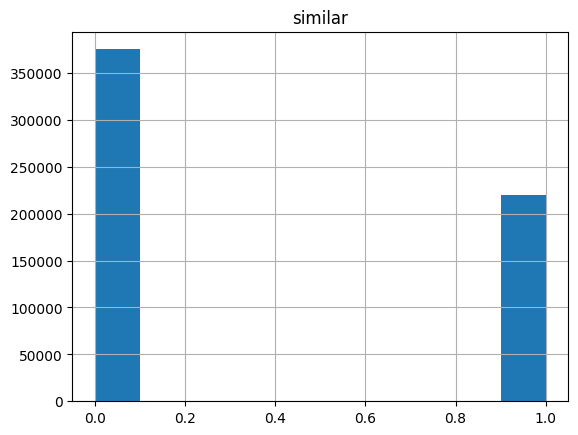

In [13]:
result.hist()